# Project 4:  House Price Prediction in Ames, IA
## Team:  Little Deuce
### Eric Lundy & Jill Cheney

### Task:
This project aims to predict the housing sale price for homes in Ames, Iowa.  This is part of a Kaggle Competition  ["House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation).  In the competition, submissions are evaluated on the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. This project follows this criteria when predicting the housing sale prices.

The report is divided up as follows:

[Background](#Background)

[EDA: Exploratory Data Analysis](#Exploratory-Data-Analysis)

[EDA: Recommendations & Findings](#Findings-&-Recommendations)

[Model Development](#Model-Development)

### Background: 
Ames, Iowa is a relatively small state college town in the middle of Iowa.  Salient points about its demographics are listed in the picture below.

![Ames Overview](ames_overview.png)

Beyond the depicted overall positive view of the community, Ames, IA also has very good schools.  The city district has one high school, which is the top ranked high school in the state.  It has an enrollment of around 1300 students. Overall, it ranking is 97.22 and it has a national ranking of 494 per US News & World Report. Five elementary schools feed the high school.  All the elementary schools possess above average rankings between 7-9 on GreatSchools.org. 

In [307]:
# Library Imports for analysis

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import pandas as pd
import seaborn as sns
import scipy.stats as st
import statistics

In [382]:
#To visualize the whole grid
pd.options.display.max_columns = 999

#Kaggle divides the dataset already into Train and Test data
# data files used for EDA purposes
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Project defined methods for analysis

def adj_r2_score(y_test, y_pred, X_test):
    num = (1-r2_score(y_test, y_pred)) * (len(X_test)-1)
    den = (len(X_test)-len(X_test.columns)-1)
    return 1 - (num / den)

### Exploratory Data Analysis

The training dataset possesses 1460 house sales with 79 separate explanatory variables, which are a collection of numerical and categorical ones.  Depicted below is a sampling of the different types of variables.

In [370]:
train[['LotArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'HeatingQC', 
       'SalePrice']].head()

,LotArea,GarageCars,GrLivArea,OverallQual,HeatingQC,SalePrice
0,63887,2,5642,10,Ex,160000
1,40094,3,4676,10,Ex,184750
2,15623,3,4476,10,Ex,745000
3,21535,3,4316,10,Ex,755000
4,35760,3,3627,10,Ex,625000


In [371]:
train[['LotArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'HeatingQC', 
       'SalePrice']].describe(include = 'all')

,LotArea,GarageCars,GrLivArea,OverallQual,HeatingQC,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000
unique,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,NaN,NaN,Ex,NaN
freq,NaN,NaN,NaN,NaN,741,NaN
mean,10516.828082,1.767123,1515.463699,6.099315,NaN,180921.195890
std,9981.264932,0.747315,525.480383,1.382997,NaN,79442.502883
min,1300.000000,0.000000,334.000000,1.000000,NaN,34900.000000
25%,7553.500000,1.000000,1129.500000,5.000000,NaN,129975.000000
50%,9478.500000,2.000000,1464.000000,6.000000,NaN,163000.000000
75%,11601.500000,2.000000,1776.750000,7.000000,NaN,214000.000000


The sale price, the dependent variable, has a mean of 180,000 USD.  The histogram depicted below captures the right-skewed (positive) distribution present in the data.  To address the skew and to normalize the data, a log transformation was done.

Skew is: 1.882876
Kurtosis is: 6.536282


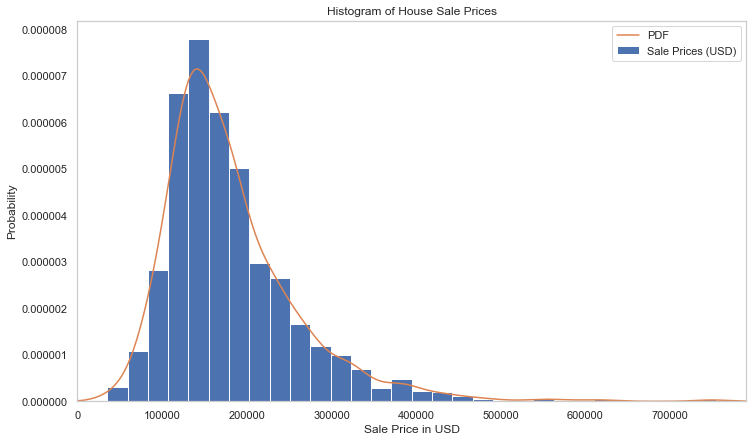

In [372]:
plt.figure(figsize = (12,7))
x = train.SalePrice
plt.hist(x, density = True, bins = 30, label = "Sale Prices (USD)")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label = "PDF")
plt.grid()
plt.legend(loc = "upper right")
plt.ylabel('Probability')
plt.xlabel('Sale Price in USD')
plt.title("Histogram of House Sale Prices")

print("Skew is:", "%3f" % train.SalePrice.skew())
print("Kurtosis is:", "%3f" % train.SalePrice.kurt())

Text(0.5, 1.0, 'Histogram of House Sale Prices')

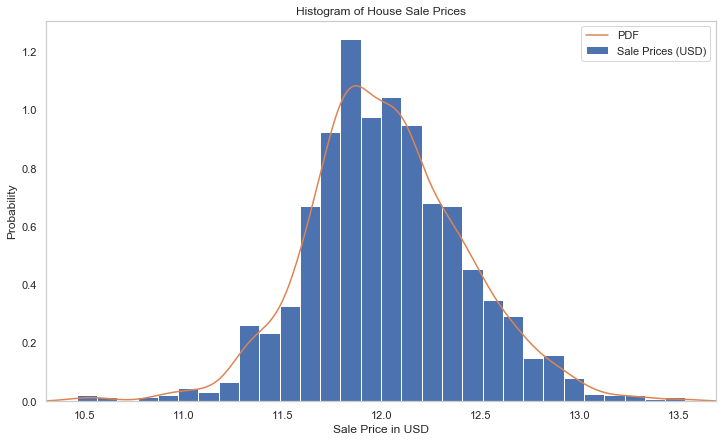

In [373]:
plt.figure(figsize = (12,7))
x = np.log(train.SalePrice)
plt.hist(x, density = True, bins = 30, label = "Sale Prices (USD)")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label = "PDF")
plt.grid()
plt.legend(loc = "upper right")
plt.ylabel('Probability')
plt.xlabel('Sale Price in USD')
plt.title("Histogram of House Sale Prices")

The logistic transformation allowed the data set to essentially fit a Gaussian distribtuion, which is depicted by the PDF line on the graph.  It is this transformed sale price that will be used for follow-on analysis.

In [374]:
# Transform SalePrice varialbe to a log value
train.SalePrice = np.log(train.SalePrice)

### Overall Housing Price Trend
Historically, an overall positive trend in housing sale price exists in Ames, IA.

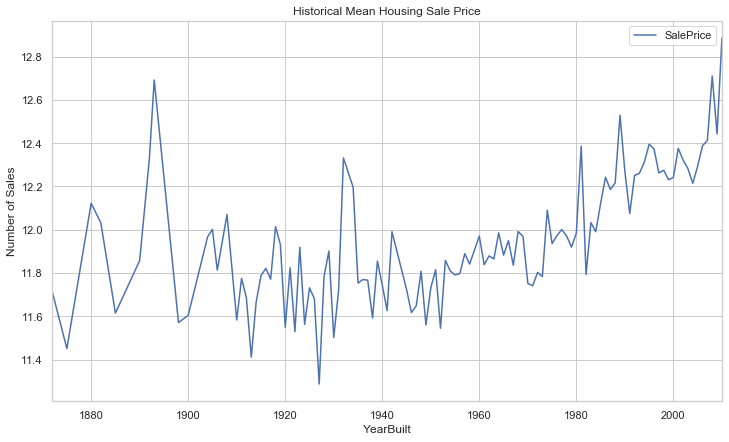

In [375]:
train[['YearBuilt', 'SalePrice']].groupby(['YearBuilt'], 
                                          as_index = True).mean().plot(figsize = (12,7))
plt.title('Historical Mean Housing Sale Price');
plt.ylabel('Number of Sales');                            

### Initial Correlation Assessments

In [376]:
# Obtain correlations of each of the numerical categories to the SalePrice
corr = train.corr(method = 'pearson')
sale_corr = corr.iloc[[0,-1]].T
print("Total number of numerical categories: ", len(sale_corr), '\n')

# isolate the top variables that correlate to sale price statistically
most_corr = sale_corr['SalePrice'].sort_values(ascending = False)[:21]
print("Most statistically correlated parameters to SalePrice: ", '\n')
print(most_corr, '\n'*2)

# isolate the variables that correlate least to sale price staticstically
least_corr = sale_corr['SalePrice'].sort_values()[:-20]
print("Least statistically correlated parameters to SalePrice: ", '\n')
print(least_corr)

Total number of numerical categories:  38 

Most statistically correlated parameters to SalePrice:  

SalePrice       1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489449
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355878
WoodDeckSF      0.334135
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
LotArea         0.257320
Name: SalePrice, dtype: float64 


Least statistically correlated parameters to SalePrice:  

EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
Id              -0.017942
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.

Supporting heat map for correlation evaluation.  

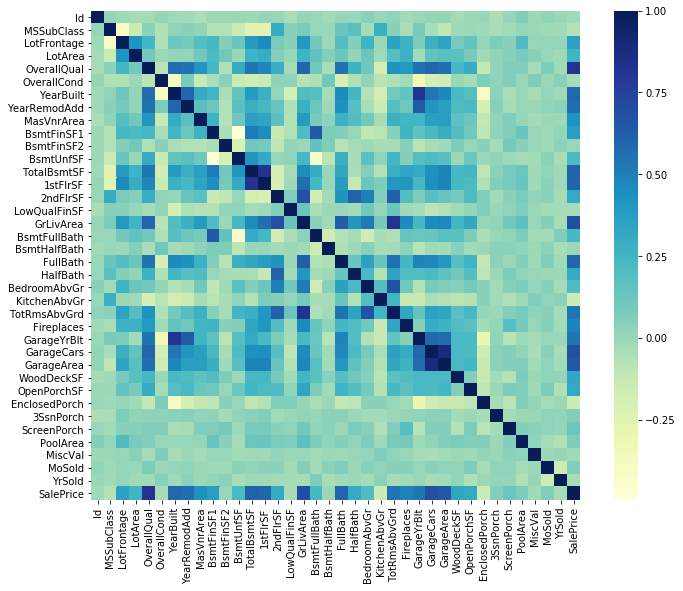

In [10]:
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr, square = True, cmap ="YlGnBu")

The initial method to isolate key variables involved assessing the top 10 most correlated variables in the dataset to the sale price.  Evaluation of these parameters is below.

#### House Quality
The overall quality of the house had the highest correlation to the sale price at 0.817.  It has an encompassing aspect to it, which could support collinearity with other features.  It is consistent to keep this feature, though will remain cautious as other features are included in th edescriptive collection.

#### Living Area
This was followed closely by 'GrLivArea'. This term represents the total square footage of the house at and above grade level.  Multiple terms in the data set depict square footage amounts in the houses by floor, though this is the only one that made it into the top ten.  Using all of the terms would be redundant and generate multi-collinearity.  Given its comparative weight to the other options to evalute house size, this term appears to best capture the size of the house.

#### Garage Size
The size of the garage based on number of cars was in the top ten, as was the size of the garage by sqaure footage.  These two values do not express distict features; rather, they are two ways of expressing the same aspect of a house.  Opting to use the more traditional description of 'number of cars' to represent garage size, provides the best represenation of this aspect of the house.  Another garage element that made it into the top ten was the year it was built.  Given the age of many of the houses, and the fact that garages were undoubtedly later additions to the property, this term was excluded.  Not only does it possess multi-collinearity within the garage parameter, it doesn't highlight the essential element of the feature, namely its size.

#### Basement
Total basement size possessed high collinearity to the sale price.  Basements come in many forms which are captured by various features.  They could be finished or not, and have a spectrum of quality, condition and finish.  In all, 11 parameters convey data about the basement. Essentially all the basements are full walk-in height (no crawl spaces) and are not in poor condition.  Given the location of Ames, IA, basements function not just for storage or extra living space, they also serve as storm cellars during tornado season.  Simply possessing a walk-in basement of acceptable that can support a variety of purposes represented the starting premise for this house feature.

#### Bathrooms
Not surprisingly, the existance of a full bathroom in the house represented a top ten item.  Additional bathroom parameters exist, but did not make it into the top ten.  Analysis will start with the full bathroom parameter.  The half-bath data point appears to possess more useful information as it relates to sale price.  In general, homes with higher sale prices possess half-baths as well as full baths.  This is logical, as all homes would have at least one full bath; however, only larger, and more expensive homes would have full and half-baths combinations.

#### Construction Year
Two variables provide information on construction.  One is the original build year.  The other is the year of remodeling.  No missing values exist for these two parameters, though not all homes have been remodels.  The convention used was if a home has been remodeled, these two variables have different years.  If no remodel has occurred, then the build year is the remodel year.  Acknowledging that a renovated old home is now a much newer one, especially as it relates to maintenance costs, initial assessments will be done with the remodel year, though the build year will be kept, as it also conveys unique data for sale pricing.

### EDA Findings & Recommendations

#### Survivors from the Top 10 Analysis
Seven of the top ten variables will initially be used to inform the modeling process.  These variables are:
<ol>
    <li>OverallQual:  Overall quality of the house</li>
    <li>GrLivArea:  house square footage at and above ground level</li>
    <li>GarageCars:  number of cars that will fit in the garage</li>
    <li>TotalBsmtSF:  total square footage of the basement</li>
    <li>FullBath:  number of full baths in the house</li>
    <li>YearBuilt:  year house was built</li>
    <li>YearRemodAdd:  year house was remodeled</li>
</ol>

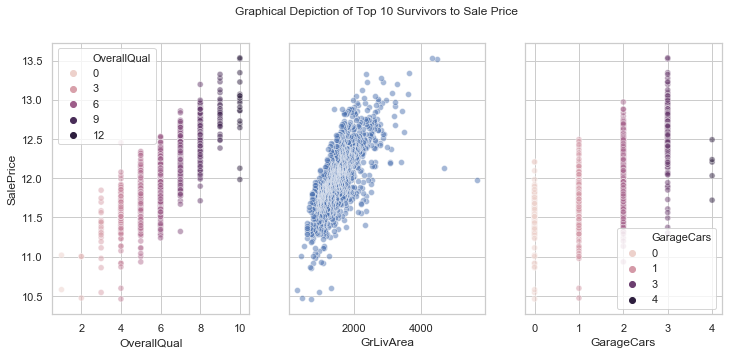

In [208]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,5), sharey = True)
fig.suptitle("Graphical Depiction of Top 10 Survivors to Sale Price")
sns.scatterplot(x = 'OverallQual', y = 'SalePrice', data = train, hue = 'OverallQual',
                ax = axs[0], alpha = 0.5)
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train,
                ax = axs[1], alpha = 0.5)
sns.scatterplot(x = 'GarageCars', y = 'SalePrice', data = train, hue = 'GarageCars',
                ax = axs[2], alpha = 0.5)
# sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train, ax = axs[1,0], alpha = 0.5)


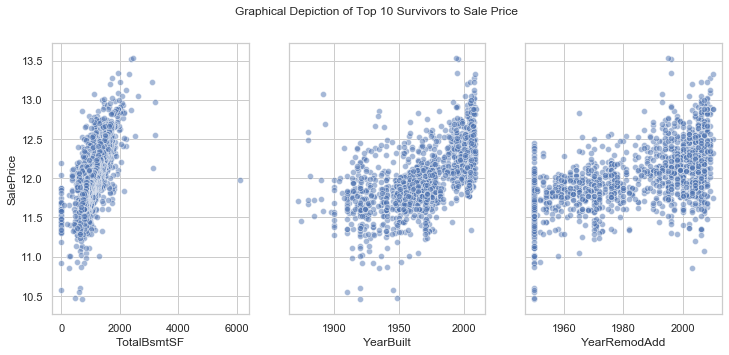

In [209]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,5), sharey = True)
fig.suptitle("Graphical Depiction of Top 10 Survivors to Sale Price")
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train, ax = axs[0], alpha = 0.5)
sns.scatterplot(x = 'YearBuilt', y = 'SalePrice', data = train, ax = axs[1], alpha = 0.5)
sns.scatterplot(x = 'YearRemodAdd', y = 'SalePrice', data = train, ax = axs[2], alpha = 0.5)

Thoughts.....

### Supporting Variable Analysis

Beyond the initial set of variables, the reamining variables were evaluated against sale price to understand their contributions and relationship to the sale price of a house.  From this, several features emerged with positive aspects worth considering.  The intent was either to include additional features or to replace existing ones with improved indicators.

##### Bathroom Comparison
Comparative performance of full bath to half-bath variable.  More expensive homes tend to have half-baths as well as full baths.  The former varaiable may provide a more nuanced perspective on a home's sale price.

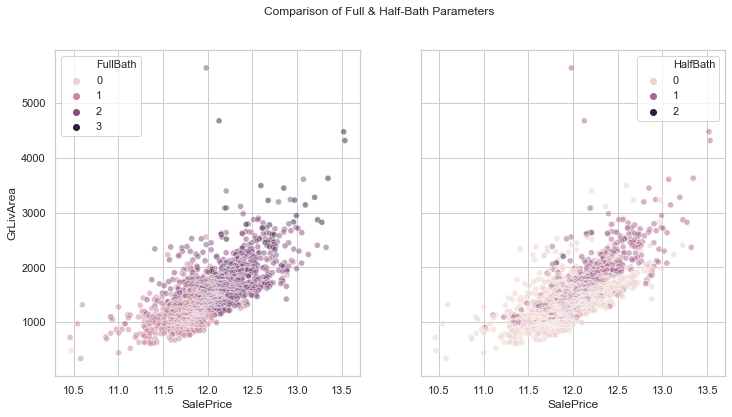

In [210]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6), sharey = True)
fig.suptitle("Comparison of Full & Half-Bath Parameters")
sns.scatterplot(x = 'SalePrice', y = 'GrLivArea', data = train, ax = axs[0], hue = 'FullBath', alpha = 0.5)
sns.scatterplot(x = 'SalePrice', y = 'GrLivArea',data = train, ax = axs[1], hue = 'HalfBath', alpha = 0.5)
sns.set(style = 'whitegrid',)
plt.show()

#### Quality of House Elements:  Kitchen & Exterior

Beyond the already identified importance of the overall quality of the home, these features possess a positive correlation to the sale price.  Arguably, a portion of this information would be included in the overall quality feature; however, given their unique nature, as well as the cost of addressing any lingering issues around them, assessing their influence is prudent.  They possess an ordinal quality about them which indicates that there is a rank order represented in the entries which informs the model.  This information needs to be converted into numerical data for inclusion in a machine learning model.  Label encoding and Hot key encoding will not maintain the ordinality of the dataset.  Given that, a direct replacment approach will best retain the information resident in the data set.

In [223]:
# replace categorigal references with numerical descriptors for ML evaluation
train.ExterQual = train.ExterQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2})
print(train.ExterQual.describe())

train.KitchenQual = train.KitchenQual.replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2})
print(train.KitchenQual.describe())

count    1460.00000
mean        3.39589
std         0.57428
min         2.00000
25%         3.00000
50%         3.00000
75%         4.00000
max         5.00000
Name: ExterQual, dtype: float64
count    1460.000000
mean        3.511644
std         0.663760
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: KitchenQual, dtype: float64


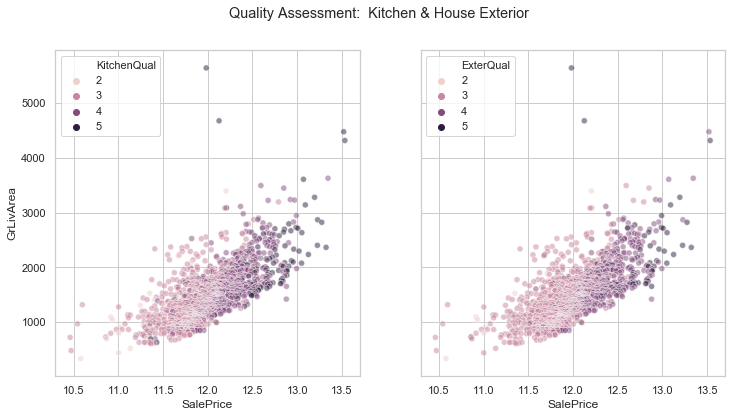

In [226]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6), sharey = True)
fig.suptitle("Quality Assessment:  Kitchen & House Exterior")
sns.scatterplot(x = 'SalePrice', y = 'GrLivArea', data = train, ax = axs[0], hue = 'KitchenQual', alpha = 0.5)
sns.scatterplot(x = 'SalePrice', y = 'GrLivArea',data = train, ax = axs[1], hue = 'ExterQual', alpha = 0.5)
sns.set(style = 'whitegrid',)
plt.show()

A definitive positive trend exists with these features.  It particular, the good and excellent entries (4 & 5 on the scales above) have a positive influence.  To combine the entires and evaluate the features with less granularity, ratings 4 & 5 will be combined into one group.

In [233]:
train['Kitchen_Score'] = train.KitchenQual
train.Kitchen_Score = train.Kitchen_Score.replace({5:5, 4:5, 3:3, 2:2})
print(train.Kitchen_Score.describe())

train['Exterior_Score'] = train.ExterQual
train.Exterior_Score = train.Exterior_Score.replace({5:5, 4:5, 3:3, 2:2})
print(train.Exterior_Score.describe())

count    1460.000000
mean        3.913014
std         1.036005
min         2.000000
25%         3.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: Kitchen_Score, dtype: float64
count    1460.000000
mean        3.730137
std         0.978057
min         2.000000
25%         3.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: Exterior_Score, dtype: float64


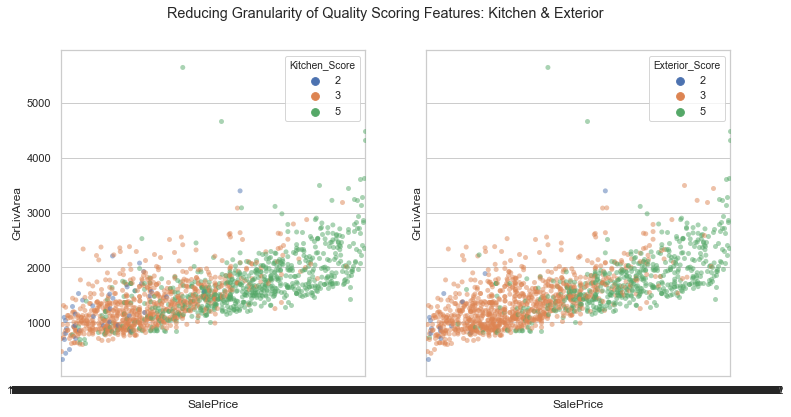

In [238]:

fig, axs = plt.subplots(ncols = 2, figsize=(12,6), sharey = True)
fig.suptitle("Reducing Granularity of Quality Scoring Features: Kitchen & Exterior")
sns.stripplot(x = 'SalePrice', y = 'GrLivArea', data = train, ax = axs[0], hue = 'Kitchen_Score', alpha = 0.5)
sns.stripplot(x = 'SalePrice', y = 'GrLivArea',data = train, ax = axs[1], hue = 'Exterior_Score', alpha = 0.5)
sns.set(style = 'whitegrid',)
plt.show()

##### Garage Configuration

Another noticable positive correlation found in the data set involved whether the garage was attached to the house or not.  Within the 'GarageType' feature, several different categorical options existed to capture the garage situation.  To consolidate these into managable groups, the following three were used:  Attached, Detached or None.  Six homes had two types of garages (attached and detached).  These homes were categorized into the attached group, as that configuration had highter sale value than the detached. 

In [280]:
# replace cateorigal references with numerical descriptors for ML evaluation
train['GarageType'].fillna(0, inplace = True)
train['Garage_Score'] = train.GarageType
train.Garage_Score = train.Garage_Score.replace({'2Types':5, 'Attchd':5, 
                                             'Basment':5, 'BuiltIn':5, 
                                             'CarPort':3, 'Detchd':3, 'NA': 0, 0:0})

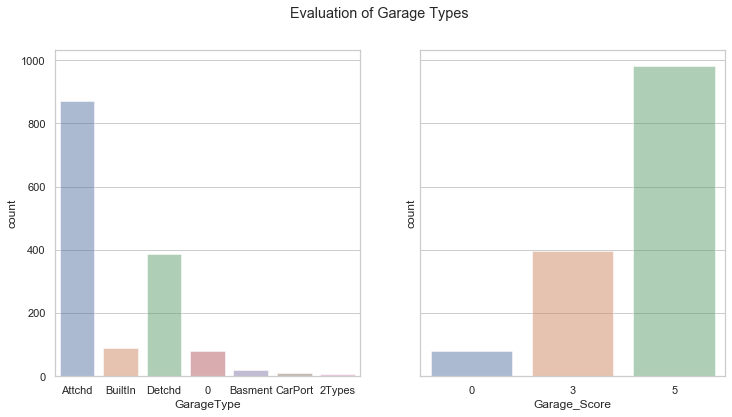

In [281]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6), sharey = True)
fig.suptitle("Evaluation of Garage Types")
sns.countplot(x = 'GarageType', data = train, ax = axs[0], alpha = 0.5)
sns.countplot(x = 'Garage_Score', data = train, ax = axs[1], alpha = 0.5)
sns.set(style = 'whitegrid',)
plt.show()


##### Sale Condition
The sale condition feature has several interesting nuances within it. The majority of the sales are normal, which is a positive for the area.  82% of the sales (1198) are in this category.  The mean sale price for this type of sale is 186K.  This is slightly higher than the overall average for the set, which is 183.5K.  Several of the other categories target sale scenarios that create a depressed sale price.

Within the dataset, there is no underlying current of foreclosures, which would be in the 'abnormal' category.  Overall, this represents 7% of the sales, or about 1.7% of annual home sales.  It is present, but not overbearing, or indiciative of an underlying economic issue.  These 101 values in the train set have a mean value of 147.6K

Sales between family members are uniquely captured in the data set.  20 are represented in the training set, which is just over 1% of total sales.  Though small in number, they represent below market value sales, as one can rationally surmise would be the case.  Their average is 149.6K.

The partial sale category, which represents sales of incomplete homes, has an average over the dataset mean.  Representing 8.8% of the data, and carrying a mean of 272K, these have the potentially to skew the dataset.  Contextually, these sales provide a rich data set on the contemporary housing market.  The four years included in the dataset represent the lead up to and just after the 2009 housing crisis.  In this period, houses were selling at inflated prices, especially new builds.  That trend is perfectly depicted in this data set.   

To capture the trends which drive sales to below, at, or above market values, the original sale categories will be consolidated into three to represent the aforementioned situations.  Partial will remain as the above market driver, and normal sales will represent the at market salels.  The remainder of categories will be aggregated into a below market value pool of property sales.  This will create numerical categorical values.  Ordinal values are not necessary, as no heiracherical relationship exists between the groups.

All of these sales ratios are consisent with what is in the test data set.  Developing a method on the training set should provide an effective start point for the model.


In [469]:
# replace cateorigal references with numerical descriptors for ML evaluation
train['SaleCondition'].fillna(0, inplace = True)
train['Sale_Score'] = train.SaleCondition
train.Sale_Score = train.Sale_Score.replace({'Normal':2, 'Abnorml':1, 
                                             'AdjLand':1, 'Alloca':1,
                                             'Family':1, 'Partial':3, 0:0})

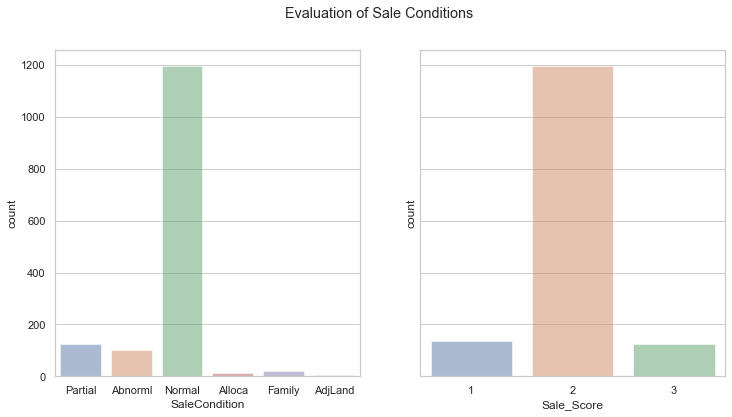

In [285]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6), sharey = True)
fig.suptitle("Evaluation of Sale Conditions")
sns.countplot(x = 'SaleCondition', data = train, ax = axs[0], alpha = 0.5)
sns.countplot(x = 'Sale_Score', data = train, ax = axs[1], alpha = 0.5)
sns.set(style = 'whitegrid',)
plt.show()

##### Lot Size

The lot area value provided in the data set was in square feet.  Though a common reference point, its continuous nature for urban homes presents an interpretation challenge.  To standardize the reference point, the lot area was converted to acres.  It was then further aggregated into groupings based on traditional break points, namely 0.25, 0.50, 0.75, 1.0, and 1.5 acre lots.  Given the urban nature, very few homes possess large lots.  After review of the number and mean price of homes in these lot groupings, the total number was reduced.  The categories that provide standard and informative groupings as it relates to sale price are:  0.25, 0.50, 0.75 and 1.0 acre and large lots.

In [359]:
# replace cateorigal references with numerical descriptors for ML evaluation
# [0, 10890, 21781, 32670, 43560] = [0, 0.25, 0.50, 0.75, 1.0] acres respectively
train['LotArea'].fillna(0, inplace = True)
train['Lot_Score'] = train.LotArea
train.Lot_Score = pd.cut(train.Lot_Score, bins = 
                         [0, 10890, 21781, 32670, 43560], labels = [1,2,3,4])

# train['Lot_Score'].value_counts() #[1000,420,21,8,6]
lot_counts = train['Lot_Score'].value_counts(normalize = True)
lot_means = train['SalePrice'].groupby(train.Lot_Score).mean()
print(lot_counts)
print(lot_means)

1    0.691085
2    0.290256
3    0.014513
4    0.004147
Name: Lot_Score, dtype: float64
Lot_Score
1    11.913352
2    12.256695
3    12.232511
4    12.340570
Name: SalePrice, dtype: float64


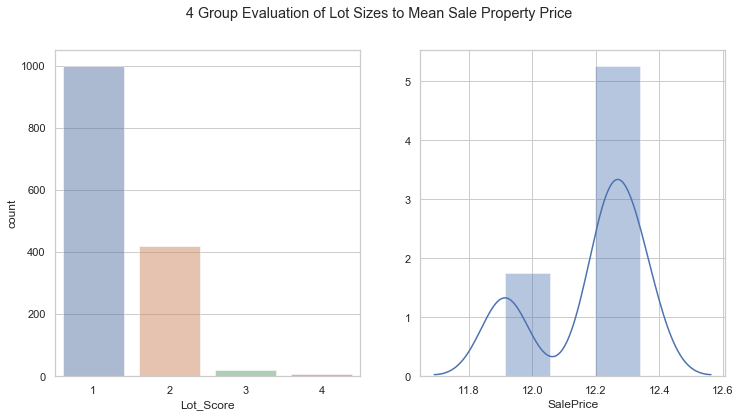

In [360]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6),)
fig.suptitle("4 Group Evaluation of Lot Sizes to Mean Sale Property Price")
sns.countplot(x = 'Lot_Score', data = train, ax = axs[0], alpha = 0.5)
sns.distplot(train['SalePrice'].groupby(train.Lot_Score).mean(), ax = axs[1])
sns.set(style = 'whitegrid',)
plt.show()

An interesting dip emerges for properties with the 0.50 to 0.75 acre lots.  First, there is a small number of them (21).  Second, their average sale price is lower than the groups on either side of them.  Characteristics of this group include:
<ol>
    <li>Homes are either older (turn of the 20th Century) or 1960's development builds.</li>
    <li>Remodels are not that recent if the do exist.</li>
    <li>Home sizes are modest.</li>
    <li>Overall quality above set average, but well below adjacent groups.</li>
</ol>

In [361]:
print(train.OverallQual.mean())
train['OverallQual'].groupby(train.Lot_Score).mean()

6.0993150684931505


Lot_Score
1    5.844000
2    6.671429
3    6.142857
4    7.000000
Name: OverallQual, dtype: float64

Though curious, it cannot be known if this is a feature of this training set or properties of this type in the area at large.  What is evident is that its level of urban density is not sufficient to have a marked affect on the lot size value.  Driving and parking do not represent mobility constraints in Ames, IA.  This 4 level grouping will be the start point.  Depending on results, this feature can be tweaked to mask this aspect in the data.  

In [362]:
# replace cateorigal references with numerical descriptors for ML evaluation
# [0, 10890, 21781, 32670, 43560] = [0, 0.25, 0.50, 0.75, 1.0] acres respectively
train['LotArea'].fillna(0, inplace = True)
train['Lot_Score_2'] = train.LotArea
train.Lot_Score_2 = pd.cut(train.Lot_Score_2, bins = 
                         [0, 10890, 21781, 43560], labels = [1,2,4])

# train['Lot_Score'].value_counts() #[1000,420,21,8,6]
lot_counts_2 = train['Lot_Score_2'].value_counts(normalize = True)
lot_means_2 = train['SalePrice'].groupby(train.Lot_Score_2).mean()
print(lot_counts_2)
print(lot_means_2)

1    0.691085
2    0.290256
4    0.018659
Name: Lot_Score_2, dtype: float64
Lot_Score_2
1    11.913352
2    12.256695
4    12.256524
Name: SalePrice, dtype: float64


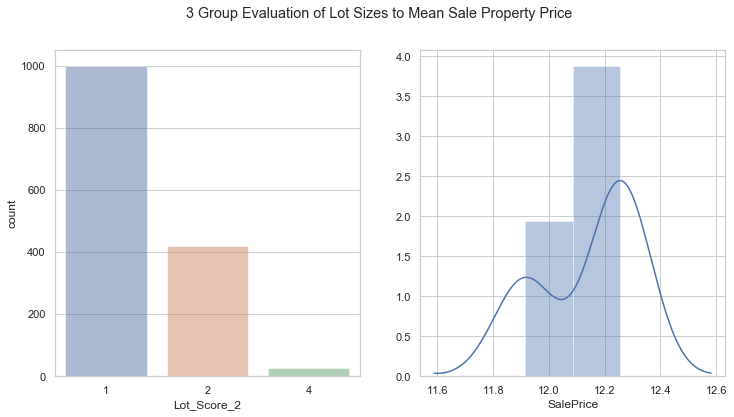

In [363]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6),)
fig.suptitle("3 Group Evaluation of Lot Sizes to Mean Sale Property Price")
sns.countplot(x = 'Lot_Score_2', data = train, ax = axs[0], alpha = 0.5)
sns.distplot(train['SalePrice'].groupby(train.Lot_Score_2).mean(), ax = axs[1])
sns.set(style = 'whitegrid',)
plt.show()

### Supporting Variable Recommendations

<ol>
    <li>Bathroom.The half-bath parameter provides a more targeted positive relationship to the sale price than the full bath option.</li>
    <li>Quality of house components.  Include the 'ExterQual' and 'KitchenQual' features but with reduced graunlarity depicted in their respective new features:  Exterior_Score and Kitchen_Score.</li>
    <li>Garage Configuration.  Attached & built-in ones have a marked positive correlation to price.  Restructure the feature to aggregate on attached, detached or none, as modeled in developed Garage_Score feature.</li>
    <li> Sale Condition.  Aggregate sales into categories which align to below, at, or above market value indicators.</li>
    <li>Lot Size. Unique nuances emerged after reviewing this feature.  Restructuring the data so that is evaluates the lots by acrage and then placing them into groups proves most beneficial for comparative analysis. The initial grouping are an estimate due to the anomaly uncovered in the 0.50 - 0.75 ac homes in the training set.  Recommend starting with four groups and compare with lots with three groups.  Create independent features to facilitate this comparison.</li>
</ol>


### Review of collected features with positive influence on the sale price
<ol>
    <li>7 of the 10 most correlated features present.  Evaluated by correlation only.</li>
    <li>Replacement of one of the 7 with an alternative with more descriptive power (bathroom).</li>
    <li>5 additional supporting features captured in new features developed from contextual analysis of the data and contemporary information.</li>
</ol>
Total number of features heading into model development:  12 

### Model Development

#### Data Pre-processing

To efficiently approach the data standardizations needed to inform models, the train and test data sets will be concatenated together.  This will allow all the sets to be updated together.

In [444]:
# copy of data set for modeling purposes
# changes identified during EDA will be uniformly applied to this data set
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Join Train & Test datasets together
data = pd.concat([train_data, test_data], ignore_index = True, sort = False)
print(train_data.shape, test_data.shape, data.shape)
# Started....but then stopped here on the joint dataset.....just adjusted the training set

(1460, 81) (1459, 80) (2919, 81)


In [445]:
# All cleaning and processing done on the train_data copy of the dataset for continuity & consistency

# Tasks:
    # Establish initial data set size & compare to end data set size
    # Drop variables that are not needed
    # Identify variables with 'NaN' values
    # Covert categorical variables into usable terms
    # Create new variables identified in the EDA
    # Reconfigure existing variables identified in the EDA
    # Assess a way forward for outliers
    
print(train_data.shape) # validate data set size is (1460,81)    

(1460, 81)


In [446]:
# drop columns that are not needed
train_data.drop(columns=['GarageArea', 'GarageCond', 'Heating', 'CentralAir', 
                         'RoofMatl', 'BsmtQual', 'BsmtCond', 'ExterCond', 'Electrical',
                         'Street','Alley', 'LotShape', 'LandContour','Utilities', 
                         'LotConfig', 'LandSlope', 'Neighborhood', 'RoofStyle', 'PoolQC', 
                         'Fence', 'MiscFeature', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                         'Foundation', 'BsmtExposure', 'BsmtFinType1', 
                         'BsmtFinType2', 'LotFrontage', 'GarageFinish', 'MasVnrArea', 
                         'FireplaceQu', 'PoolArea', 'BldgType', 'HouseStyle','Condition1',
                         'Condition2', 'OverallCond','KitchenAbvGr', 'BedroomAbvGr', 
                         'Functional', 'GarageYrBlt', 'MSZoning', 'BsmtFinSF1', 'BsmtFinSF2',
                         'BsmtUnfSF', '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 
                         'BsmtHalfBath'], 
                inplace=True)  # total:  51 features

print(train_data.shape) # validate data set size is (1460,30)

(1460, 30)


In [447]:
# confirm presence of variables with NaN
print(train_data.isna().any()[lambda x: x])

# GarageType - Type of garage house possesses
train_data['GarageType'].fillna(0, inplace = True)
# GarageQual - Quality of garage house possesses
train_data['GarageQual'].fillna(0, inplace = True)

print(train_data.isna().any()[lambda x: x])

GarageType    True
GarageQual    True
dtype: bool
Series([], dtype: bool)


In [448]:
# finding null values in dataset
null_values = train_data.isnull().sum()/train_data.shape[0]*100
print(null_values)

Id               0.0
MSSubClass       0.0
LotArea          0.0
OverallQual      0.0
YearBuilt        0.0
YearRemodAdd     0.0
ExterQual        0.0
TotalBsmtSF      0.0
HeatingQC        0.0
GrLivArea        0.0
FullBath         0.0
HalfBath         0.0
KitchenQual      0.0
TotRmsAbvGrd     0.0
Fireplaces       0.0
GarageType       0.0
GarageCars       0.0
GarageQual       0.0
PavedDrive       0.0
WoodDeckSF       0.0
OpenPorchSF      0.0
EnclosedPorch    0.0
3SsnPorch        0.0
ScreenPorch      0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
SalePrice        0.0
dtype: float64


In [450]:
# Exterior Quality adjustments 
train_data['Exterior_Score'] = train_data.ExterQual
train_data.Exterior_Score = train_data.Exterior_Score.replace({'Ex':5, 'Gd':5, 'TA':3, 'Fa':2})
# print(train_data.Exterior_Score.describe())

# Kitchen Quality Adjustments
train_data['Kitchen_Score'] = train_data.KitchenQual
train_data.Kitchen_Score = train_data.Kitchen_Score.replace({'Ex':5, 'Gd':5, 'TA':3, 'Fa':2})
# print(train_data.Kitchen_Score.describe())

# Garage Type Adjustments 
train_data['GarageType'].fillna(0, inplace = True)
train_data['Garage_Score'] = train_data.GarageType
train_data.Garage_Score = train_data.Garage_Score.replace({'2Types':5, 'Attchd':5, 
                                             'Basment':5, 'BuiltIn':5, 
                                             'CarPort':3, 'Detchd':3, 'NA': 0, 0:0})

# Sale Condition Adjustments - direct replacement instead of dummy variable option 
train_data['SaleCondition'].fillna(0, inplace = True)
train_data['SaleCondition'].fillna(0, inplace = True)
train_data['Sale_Score'] = train_data.SaleCondition
train_data.Sale_Score = train_data.Sale_Score.replace({'Normal':2, 'Abnorml':1, 
                                             'AdjLand':1, 'Alloca':1, 
                                             'Family':1, 'Partial':3, 0:0})

# Lot Area Adjustments
# 4 Group Version
# [0, 10890, 21781, 32670, 43560] = [0, 0.25, 0.50, 0.75, 1.0] acres respectively
train_data['LotArea'].fillna(0, inplace = True)
train_data['Lot_Score'] = train_data.LotArea
train_data.Lot_Score = pd.cut(train_data.Lot_Score, bins = 
                         [0, 10890, 21781, 32670, 43560], labels = [1,2,3,4])

# 3 Group Version
# [0, 10890, 21781, 43560] = [0, 0.25, 0.50, 1.0] acres respectively
train_data['LotArea'].fillna(0, inplace = True)
train_data['Lot_Score_2'] = train_data.LotArea
train_data.Lot_Score_2 = pd.cut(train_data.Lot_Score_2, bins = 
                         [0, 10890, 21781, 43560], labels = [1,2,4])

print(train_data.shape) # validate data set size is (1460,36) - 6 feature vectors added

# confirm absence of any NaN values
new_var = ['Exterior_Score', 'Kitchen_Score', 'Garage_Score', 'Sale_Score', 
           'Lot_Score', 'Lot_Score_2']
for x in new_var:
    nan_check = train_data[x].isnull().values.any()
    print(nan_check)

train_data.loc[train_data['Lot_Score'].isnull(), 'NaN_positive'] = 'Yes'
print(train_data['Lot_Score'].isnull().sum())

train_data.loc[train_data['Lot_Score_2'].isnull(), 'NaN_positive'] = 'Yes'
print(train_data['Lot_Score_2'].isnull().sum())

train_data['Lot_Score'] = train_data['Lot_Score'].replace(np.nan,0)
train_data['Lot_Score_2'] = train_data['Lot_Score_2'].replace(np.nan,0)

# recheck for no NaN values
for x in new_var:
    nan_check = train_data[x].isnull().values.any()
    print(nan_check)

(1460, 36)
False
False
False
False
True
True
13
13
False
False
False
False
False
False


In [451]:
print(train_data[['Exterior_Score', 'Kitchen_Score', 'Garage_Score', 'Sale_Score', 
       'Lot_Score', 'Lot_Score_2']].describe())


       Exterior_Score  Kitchen_Score  Garage_Score    Lot_Score  Lot_Score_2
count     1460.000000    1460.000000   1460.000000  1460.000000  1460.000000
mean         3.730137       3.913014      4.180137     1.319863     1.334247
std          0.978057       1.036005      1.342004     0.537570     0.592903
min          2.000000       2.000000      0.000000     0.000000     0.000000
25%          3.000000       3.000000      3.000000     1.000000     1.000000
50%          3.000000       3.000000      5.000000     1.000000     1.000000
75%          5.000000       5.000000      5.000000     2.000000     2.000000
max          5.000000       5.000000      5.000000     4.000000     4.000000


In [452]:
# # Transform SalePrice variable to a log value & make it the train_label value
train_labels = np.log(train_data.SalePrice)

# # Remove the ID and the sale price for the training data since these will not be need for prediction
# train_data = train_data.drop(['Id','SalePrice'], axis=1)

# split training data into an 80/20 configuration for train and dev groups
train_data, dev_data, train_labels, dev_labels = train_test_split(train_data, train_labels, test_size=0.2)

###  Model 1

In [454]:
# Model #1:  Test prior to extensive EDA on 3 parameters (SF, Quality, & build year)
# Split a development data set out of the original training set

# Initial model with three explanatory variables
lr = LinearRegression()
x = train_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.18
R-Squared: 0.763
Adj R-Squared 0.728


### Model 2

In [455]:
# Model 2:  The 7 survivoring parameters of the top ten correlated ones
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF']]
y = np.log(train_labels)

lr.fit(x, y)

y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.15
R-Squared: 0.827
Adj R-Squared 0.802


### Model 3

In [460]:
# Model 3:  Model 2 but with the Bathroom Feature swapped from 'FullBath' to 'HalfBath'
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'HalfBath', 'YearRemodAdd', 
                                         'TotalBsmtSF']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))
      
# Ever so slight improvement.....

Root Square Mean Error: 0.15
R-Squared: 0.83
Adj R-Squared 0.805


### Model 4

In [463]:
# Model 4:  The 7 survivors + quality features(Kitchen & Exterior)
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF', 
                       'Kitchen_Score', 'Exterior_Score']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'Kitchen_Score','Exterior_Score']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.16
R-Squared: 0.827
Adj R-Squared 0.802


### Model 5

In [465]:
# Model 5:  The 7 survivors + !Quality features + Garage_Score
# Quality features appear to make the model worse!
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF', 
                       'Garage_Score',]]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'Garage_Score',]])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.15
R-Squared: 0.833
Adj R-Squared 0.808


### Model 6

In [466]:
# Model 6:  The 7 survivors + !Quality features + Garage_Score + Sale_Score
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF', 
                       'Garage_Score','Sale_Score',]]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'Garage_Score',
                                         'Sale_Score',]])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.15
R-Squared: 0.836
Adj R-Squared 0.812


### Model 7

In [467]:
# Model 7:  The 7 survivors + !Quality features + Garage_Score + Sale_Score + Lot_Score
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF', 
                       'Garage_Score','Sale_Score','Lot_Score']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'Garage_Score',
                                         'Sale_Score','Lot_Score']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))

print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))

Root Square Mean Error: 0.15
R-Squared: 0.838
Adj R-Squared 0.815


### Model 8

In [468]:
# Model 8:  The 7 survivors + !Quality features + Garage_Score + Sale_Score + Lot_Score_2
# Linear Regression Model
lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF', 
                       'Garage_Score','Sale_Score','Lot_Score_2']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'Garage_Score',
                                         'Sale_Score','Lot_Score_2']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
# adj_r2 = adj_r2_score(dev_labels, np.exp(y_predicted, dev_data))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(dev_labels, np.exp(y_predicted), 
                                                dev_data), 3)))
# Not as good as the original one....

Root Square Mean Error: 0.15
R-Squared: 0.838
Adj R-Squared 0.814


# Break - Extra Stuff

In [110]:
# Remove the ID and the sale price for the training data since these will not be need for prediction
train_data = train.drop(['Id','SalePrice'], axis=1)

# take the log of saleprice to help normalize the sales price distribution
train_labels = train.SalePrice

# Tasks:
    # Establish initial data set size & compare to end data set size
    # Covert categorical variables into usable terms
    # Identify variables with 'NaN' values
    # Drop variables that are not needed
      
print(train_data.shape) # validate data set size is (1460,79)

# drop columns that are not needed
train_data.drop(columns=['GarageArea', 'GarageCond', 'Heating', 'CentralAir', 
                         'RoofMatl', 'BsmtQual', 'BsmtCond', 'ExterCond', 'Electrical',
                         'Street','Alley', 'LotShape', 'LandContour','Utilities', 
                         'LotConfig', 'LandSlope', 'Neighborhood', 'RoofStyle', 'PoolQC', 
                         'Fence', 'MiscFeature', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                         'Foundation', 'BsmtExposure', 'BsmtFinType1', 
                         'BsmtFinType2', 'LotFrontage', 'GarageFinish', 'MasVnrArea', 
                         'FireplaceQu', 'PoolArea', 'BldgType', 'HouseStyle','Condition1',
                         'Condition2'], inplace=True)

# confirm presence of variables with NaN
print(train_data.isna().any()[lambda x: x])
print(train_data.shape) #validate dataset reduces to (1460,44)

# GarageYrBlt - Year garage was built - set to average garage year build
train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace=True)
# GarageType - Type of garage house possesses
train_data['GarageType'].fillna(0, inplace = True)
# GarageQual - Quality of garage house possesses
train_data['GarageQual'].fillna(0, inplace = True)
# ExterQual - Quality of house exterior
train_data['ExterQual'].fillna(0, inplace = True)
# HeatingQC - Quality of house heating system
train_data['HeatingQC'].fillna(0, inplace = True)
# KitchenQual - Quality/Currency of kitchen
train_data['KitchenQual'].fillna(0, inplace = True)

print(train_data[['LotArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'HeatingQC', 
       'GarageType', 'HalfBath', 'ExterQual']].describe(include = 'all'))

train_data = pd.get_dummies(data=train_data, dummy_na=False, columns=['MSZoning',  
                                                                      'Functional', 'GarageQual', 
                                                                      'PavedDrive',
                                                                      'SaleType', 'SaleCondition'])


    # confirm presence of variables with NaN
print(train_data.isna().any()[lambda x: x])

print(train_data.shape)

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)

(1460, 79)
ExterQual      True
HeatingQC      True
KitchenQual    True
GarageType     True
GarageYrBlt    True
GarageQual     True
dtype: bool
(1460, 42)
              LotArea   GarageCars    GrLivArea  OverallQual  HeatingQC  \
count     1460.000000  1460.000000  1460.000000  1460.000000     1460.0   
unique            NaN          NaN          NaN          NaN        NaN   
top               NaN          NaN          NaN          NaN        NaN   
freq              NaN          NaN          NaN          NaN        NaN   
mean     10516.828082     1.767123  1515.463699     6.099315        0.0   
std       9981.264932     0.747315   525.480383     1.382997        0.0   
min       1300.000000     0.000000   334.000000     1.000000        0.0   
25%       7553.500000     1.000000  1129.500000     5.000000        0.0   
50%       9478.500000     2.000000  1464.000000     6.000000        0.0   
75%      11601.500000     2.000000  1776.750000     7.000000        0.0   
max     215245.000000

In [100]:
# Model #1:  Test prior to extensive EDA on 3 parameters (SF, Quality, & build year)
# Split a development data set out of the original training set

train_data = train[:1000]
train_labels = train.SalePrice[:1000]
dev_data = train[1000:]
dev_labels = train.SalePrice[1000:]

# Initial model with three explanatory variables
x = train_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual']]
y = np.log(train_labels)
lr = LinearRegression()
lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))

Root Square Mean Error: 0.19
R-Squared: 0.476


In [40]:
# Model 2:  The 7 kept parameters of the top ten correlated ones
# Linear Regression Model

lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'FullBath', 'YearRemodAdd', 'TotalBsmtSF']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'FullBath', 'YearRemodAdd', 
                                         'TotalBsmtSF']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
# adj_r2 = adj_r2_score(dev_labels, np.exp(y_predicted, dev_data))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2), 3))

# lr.fit(train_data, np.log(train_labels))
# predicted_labels = lr.predict(test_data)
# rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
# r2 = r2_score(test_labels, np.exp(predicted_labels))
# print('Root Square Mean Error ' + str(round(rmse, 2)))
# print('R-Squared ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

Root Square Mean Error: 0.17
R-Squared: 0.578


In [178]:
# Model 3:  
# Linear Regression Model

lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 
                       'GarageCars', 'YearRemodAdd', 'TotalBsmtSF', 
                       'HalfBath',]]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 
                                         'GarageCars', 'YearRemodAdd', 
                                         'TotalBsmtSF', 'HalfBath',]])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
# adj_r2 = adj_r2_score(dev_labels, np.exp(y_predicted, dev_data))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2), 3))

# lr.fit(train_data, np.log(train_labels))
# predicted_labels = lr.predict(test_data)
# rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
# r2 = r2_score(test_labels, np.exp(predicted_labels))
# print('Root Square Mean Error ' + str(round(rmse, 2)))
# print('R-Squared ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

Root Square Mean Error: 0.16
R-Squared: 0.628


In [17]:
# Linear Regression Model

lr = LinearRegression()
x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 'GarageCars', 'HalfBath']]
y = np.log(train_labels)

lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 'GarageCars', 'HalfBath']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
# adj_r2 = adj_r2_score(dev_labels, np.exp(y_predicted, dev_data))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2), 3))

# lr.fit(train_data, np.log(train_labels))
# predicted_labels = lr.predict(test_data)
# rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
# r2 = r2_score(test_labels, np.exp(predicted_labels))
# print('Root Square Mean Error ' + str(round(rmse, 2)))
# print('R-Squared ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

Root Square Mean Error: 0.18
R-Squared: 0.536


In [18]:
ridge = Ridge(alpha=1.0)

x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual', 'GarageCars', 'HalfBath']]
y = np.log(train_labels)

ridge.fit(x,y)
y_predicted = lr.predict(dev_data.loc[:,['GrLivArea', 'YearBuilt', 'OverallQual', 'GarageCars', 'HalfBath']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
r2 = r2_score(dev_labels, np.exp(y_predicted))
print('Root Square Mean Error: ' + str(round(rmse, 2)))
print('R-Squared: ' + str(round(r2, 3)))


# predicted_labels = ridge.predict(test_data)
# rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
# r2 = r2_score(test_labels, np.exp(predicted_labels))
# print('Root Square Mean Error ' + str(round(rmse, 2)))
# print('R-Squared ' + str(round(r2, 3)))
# print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

Root Square Mean Error: 0.18
R-Squared: 0.536
